## Grid Search

In [ ]:
from typing import Dict, List
from ddnn.nn import *
from ddnn.data import *
from ddnn.validation import *

In [ ]:
def ncomb(grid):
    comb=1
    for k,v in grid.items():
        comb*= len(v)
    return comb

net = NeuralNetwork(
    [
        LinearLayer((8, 16)),
        ActivationFunction(),
    ]
)
estimator = Estimator(net) # fix to work without anything
grid = {}
grid["layers"] = [
    [(64, "ReLU"), (2, "linear")]
    [(32, "ReLU"), (32, "ReLU"), (2, "linear")]
    [(16, "ReLU"), (16, "ReLU"), (16, "ReLU"), (16, "ReLU"), (2, "linear")],
    [   
        (8, "ReLU"), (8, "ReLU"), (8, "ReLU"), (8, "ReLU"), 
        (8, "ReLU"), (8, "ReLU"), (8, "ReLU"), (8, "ReLU"), (2, "linear")
    ]
]
grid["learning_rate"] = [1e-2, 1e-3]
grid["optimizer"] = ["Adam"]
grid["loss"] = ["MSE"]
grid["l2_coefficient"] = [1e-2, 1e-3]
grid["batchsize"] = [-1]
grid["weight_initializer"] = ["glorot_uniform"]

SEED = 123
MAX_EPOCHS = 1500
EARLY_STOPPING = (10, 5, 1e-4)
PLOT_LOSSES = ["MSE"]
EARLY_STOPPING_LOSSES = ["MSE", "MEE"]
PLOT_EVERY = 10
N_FOLDS = 5 

selector = GridSearch(estimator, grid, SEED)

ncomb(grid)

In [ ]:
data = read_ML_cup("train")
data, test = train_valid_split(data)

In [ ]:
logger = Logger(estimator, PLOT_LOSSES, every=PLOT_EVERY)

In [ ]:
results = selector.k_fold(
    data,
    N_FOLDS,
    n_epochs=MAX_EPOCHS,
    loss_list=EARLY_STOPPING_LOSSES,
    early_stopping=EARLY_STOPPING,
    seed=SEED,
    on_fold_change=logger.update_fold,
    on_hp_change=logger.update_hp,
    training_callback=logger,
)

In [ ]:
# save to file
import json

# json cannot handle int64
for item in results:
    item["seed"] = str(item["seed"])

with open("trial.json", "w") as fp:    
    savable = {
        "plot_points": logger._scores,
        "k_fold_best": results,
        "grid"       : grid,
        "plot_every" : PLOT_EVERY,
        "max_epochs" : MAX_EPOCHS,
        "early_stop" : EARLY_STOPPING,
        "grid_seed"  : SEED,
        "stop_losses": EARLY_STOPPING_LOSSES,
        "plot_losses": PLOT_LOSSES,
        "nfolds"     : N_FOLDS,
    }
    json.dump(savable, fp)

## Plotting

In [1]:
# open with pandas
import pandas as pd
import json

FILE = "./trials/initialization/glorot.random.trial.json"

with open(FILE, "r") as fp:
    save = json.load(fp)

    plot_points = save["plot_points"]
    every       = save["plot_every"]
    epochs      = save["max_epochs"]
    early_stop  = save["early_stop"]
    grid_seed   = save["grid_seed"]
    stop_losses = save["stop_losses"]
    plot_losses = save["plot_losses"]
    k_fold_best = save["k_fold_best"]
    grid        = save["grid"]
    nfolds      = save["nfolds"]

df = pd.json_normalize(plot_points)
df["hp.layers"] = df["hp.layers"].astype(str) # convert layers to str repr

In [2]:
from ipywidgets.widgets import interact_manual, interact
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

interactive(children=(Dropdown(description='loss', options=('MSE',), value='MSE'), Dropdown(description='hp.la…

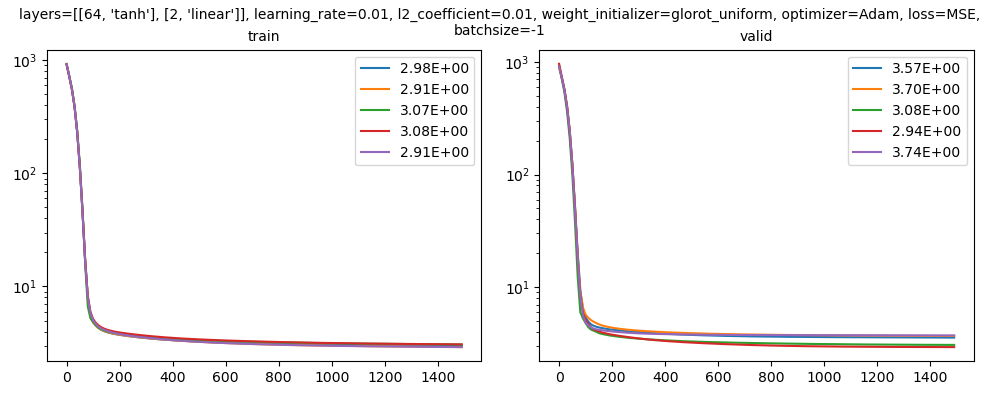

In [3]:
%matplotlib ipympl

# select loss, hyper get 2 plots one with train one with valid
fig, axs = plt.subplots(1,2, figsize=(10,4))

# hyperparameters in grid
params = {
    k: df[k].unique() 
    for k in df.columns[df.columns.str.startswith("hp.")]
}
# hyperparameters in grid with at least 2 values
fparams = {
    k: v 
    for k,v in params.items()
    if len(v) > 1
}

@interact(
    loss = plot_losses,
    **fparams
)
def plot_results(loss, **kwargs):
    row_selection = pd.Series([True]*df.shape[0])
    for k,v in kwargs.items():
        row_selection &= (df[k] == v)
    rows = df[row_selection]

    # add parameter to title if missing
    for k in params:
        if k not in kwargs:
            kwargs[k] = params[k][0]

    fig.suptitle(", ".join([f"{k[3:]}={v}" for k,v in kwargs.items()]), wrap=True, fontsize=10)
    fig.tight_layout()
    for where, ax in zip(["train", "valid"], axs):
        col_selection = rows.columns.str.endswith(f"{where}.{loss}")
        data = rows[rows.columns[col_selection]]

        ys = [y for y in data.values][0]
        if loss != "binary_accuracy":
            bests = [min(y) for y in ys]
            form = "{:.2E}"
            logplot = True
        else:
            bests = [max(y) for y in ys]
            form = "{:.2}"
            logplot = False

        ax.clear()
        ax.set_title(where, fontsize=10)
        # scale to resemble number of epochs instead of plot points
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*every))
        ax.xaxis.set_major_formatter(ticks_x)
        if logplot:
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
        for y,best in zip(ys, bests):
            ax.plot(y, label=f"{form.format(best)}")
        ax.legend()

In [4]:
k_fold_best

[{'parameters': {'layers': [[64, 'tanh'], [2, 'linear']],
   'learning_rate': 0.01,
   'optimizer': 'Adam',
   'loss': 'MSE',
   'l2_coefficient': 0.01,
   'batchsize': -1,
   'weight_initializer': 'glorot_uniform'},
  'test_loss_avg': {'MSE': 3.4055890319039035, 'MEE': 1.4429566661973525},
  'test_loss_std': {'MSE': 0.3303268864119395, 'MEE': 0.06447464708444746},
  'seed': '2716623700527019418',
  'n_epochs_list': [1491, 1491, 1491, 1491, 1491],
  'n_epoch_avg': 1491.0,
  'n_epoch_std': 0.0,
  'train_loss_avg': 2.9898967386731354,
  'train_loss_std': 0.0727324929628734},
 {'parameters': {'layers': [[64, 'tanh'], [2, 'linear']],
   'learning_rate': 0.01,
   'optimizer': 'Adam',
   'loss': 'MSE',
   'l2_coefficient': 0.01,
   'batchsize': -1,
   'weight_initializer': 'glorot_normal'},
  'test_loss_avg': {'MSE': 3.4151098157555326, 'MEE': 1.443749049124957},
  'test_loss_std': {'MSE': 0.29920029673933785, 'MEE': 0.06032380088877539},
  'seed': '7266625106340803023',
  'n_epochs_list': [

In [5]:
grid

{'layers': [[[64, 'tanh'], [2, 'linear']], [[64, 'ReLU'], [2, 'linear']]],
 'learning_rate': [0.01, 0.001],
 'optimizer': ['Adam'],
 'loss': ['MSE'],
 'l2_coefficient': [0.01, 0.001],
 'batchsize': [-1],
 'weight_initializer': ['glorot_uniform',
  'glorot_normal',
  'random_uniform',
  'random_normal']}